In [1]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
import config
from tqdm import tqdm

gen = Generator(in_channels=3)
checkpoint = torch.load("genv4.pth.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/album

In [2]:
from VGG import VGG
import config

vgg_model = VGG().to(config.DEVICE).eval()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_pth = "image_dataset/maps/val/3.jpg"
image = np.array(Image.open(image_pth))
image_x = image[:, :config.IMAGE_SIZE, ...]
image_z = image[:, config.IMAGE_SIZE:config.IMAGE_SIZE*2, ...]
image_y = image[:, config.IMAGE_SIZE*2:, ...]
x = config.transform_only_input(image=image_x)["image"]
z = config.transform_only_inter(image=image_z)["image"]
y = config.transform_only_mask(image=image_y)["image"]

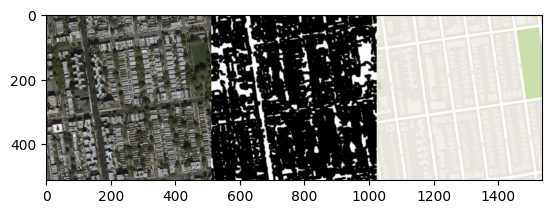

In [41]:
plt.imshow(image)

In [4]:
generated_features = vgg_model(gen(x.unsqueeze(0), z.unsqueeze(0)) * 0.5 + 0.5) # Remove unsqueeze when actuall training
style_image_features = vgg_model(y)

In [5]:
[print(i.shape) for i in generated_features]

torch.Size([1, 64, 512, 512])
torch.Size([1, 128, 256, 256])
torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])


[None, None, None, None, None]

In [6]:
[print(i.shape) for i in style_image_features]

torch.Size([64, 512, 512])
torch.Size([128, 256, 256])
torch.Size([256, 128, 128])
torch.Size([512, 64, 64])
torch.Size([512, 64, 64])


[None, None, None, None, None]

In [ ]:
style_loss = 0

for generated_feature, style_image_feature in zip(generated_features, style_image_features):
        
    batch_size, channel, height, width = generated_feature.shape
    generated_feature = generated_feature.view(batch_size, channel, height * width)
    style_image_feature = style_image_feature.view(batch_size, channel, height * width)

    # Compute Gram matrices for each image in the batch
    generated_gram_matrix = torch.bmm(generated_feature, generated_feature.transpose(1, 2))
    style_gram_matrix = torch.bmm(style_image_feature, style_image_feature.transpose(1, 2))

    # Compute style loss for the whole batch
    style_loss += torch.mean((generated_gram_matrix - style_gram_matrix) ** 2)

In [18]:
style_loss

tensor(19439.1367, grad_fn=<AddBackward0>)

In [9]:
config.BETA * style_loss

tensor(3933319., grad_fn=<MulBackward0>)

In [37]:
import torch

def calc_style_loss(generator, x, z, y):
    s_loss = 0
    generated_features = vgg_model(generator(x, z) * 0.5 + 0.5) # Remove unsqueeze when actuall training
    style_image_features = vgg_model(y)

    for generated_feature, style_image_feature in zip(generated_features, style_image_features):
        
        batch_size, channel, height, width = generated_feature.shape

        generated_gram_matrix = generated_feature.view(batch_size, channel, height*width).mm(
                                generated_feature.view(batch_size, channel, height*width).t()
                                )
                                
        style_gram_matrix = style_image_feature.view(batch_size, channel, height*width).mm(
                                style_image_feature.view(batch_size, channel, height*width).t()
                                )
        s_loss += torch.mean((generated_gram_matrix - style_gram_matrix)**2)

    return s_loss